#### Simple example of trainning a GAN for digits image generation

In [174]:
import torch
from torch import nn


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential()
        self.generator.add_module('ln1', nn.Linear(in_features=20, out_features=100, bias=False))
        self.generator.add_module('ln1_LRelu', nn.LeakyReLU())

        self.generator.add_module('ln2', nn.Linear(in_features=100, out_features=100, bias=False))
        self.generator.add_module('ln2_LRelu', nn.LeakyReLU())

        self.generator.add_module('ln2', nn.Linear(in_features=100, out_features=784))
        self.generator.add_module('ln2_Tahn', nn.Tanh())

    def forward(self, x):
        out = self.generator(x)
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential()
        # self.model.add_module('flatt0', nn.Flatten())

        self.model.add_module('ln1', nn.Linear(in_features=784, out_features=100, bias=False))
        self.model.add_module('ln1_LRelu', nn.LeakyReLU())
        self.model.add_module('drop1', nn.Dropout(p=0.5))

        self.model.add_module('ln2', nn.Linear(in_features=100, out_features=100, bias=False))
        self.model.add_module('ln2_LRelu', nn.LeakyReLU())
        self.model.add_module('drop2', nn.Dropout(p=0.5))

        self.model.add_module('ln2', nn.Linear(in_features=100, out_features=1))

    def forward(self, x):
        return self.model(x)      



In [175]:
generator = Generator()
discr = Discriminator()

latent_vect = torch.normal(0, 1, (1, 20))

imgs_batch = generator(latent_vect).view(1, 784)
discr(imgs_batch)

tensor([[-0.]], grad_fn=<MulBackward0>)

In [30]:
print(generator)

Generator(
  (generator): Sequential(
    (ln1): Linear(in_features=20, out_features=100, bias=True)
    (ln1_LRelu): LeakyReLU(negative_slope=0.01)
    (ln2): Linear(in_features=100, out_features=784, bias=True)
    (ln2_Tahn): Tanh()
  )
)


In [52]:
print(discr)

Discriminator(
  (model): Sequential(
    (ln1): Linear(in_features=784, out_features=100, bias=False)
    (ln1_LRelu): LeakyReLU(negative_slope=0.01)
    (drop1): Dropout(p=0.5, inplace=False)
    (ln2): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [42]:
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(std=(0.5), mean=(0.5))
])

root_data = "./data/mnist/train"
dataset = torchvision.datasets.MNIST(root=root_data, train=True, transform=transform, download=True)

img, label = dataset[0]
torch.max(img), torch.min(img), img.shape

(tensor(1.), tensor(-1.), torch.Size([1, 28, 28]))

In [44]:
def create_noise(batch_size, size):
    return torch.randn(batch_size, size)

create_noise(10, 20).shape    

torch.Size([10, 20])

In [133]:
from torch.utils.data import DataLoader
batch_s = 128
train_ds = DataLoader(dataset, batch_size=batch_s, shuffle=False, num_workers=20)

input_real, label_real = next(iter(train_ds))
input_real = input_real.view(batch_s, -1)
input_z = create_noise(batch_s, 20)
print(input_z.shape)

torch.Size([128, 20])


In [129]:
g_out = generator(input_z)
print('Gen out shape:', g_out.shape)

fake_probs = discr(g_out)
real_probs = discr(input_real)

fake_probs.shape, real_probs.shape

Gen out shape: torch.Size([128, 784])


(torch.Size([128, 1]), torch.Size([128, 1]))

In [177]:
from email.mime import image


device = torch.device('cuda')
loss_fn = nn.BCEWithLogitsLoss()
d_optim = torch.optim.AdamW(params=discr.parameters())
g_optim = torch.optim.AdamW(params=generator.parameters())

discr.to(device)
generator.to(device)

def train_disc(x):
    discr.zero_grad()
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)

    #Train on real Images
    labels_real = torch.ones((batch_size, 1), device=device)
    prob_real = discr(x)
    loss_real = loss_fn(prob_real, labels_real)

    #Train on fake images
    input_z = create_noise(batch_size, 20).to(device)
    fake_images = generator(input_z)
    labels_fake = torch.zeros((batch_size,1), device=device)
    prob_fake = discr(fake_images)
    loss_fake = loss_fn(prob_fake, labels_fake)

    loss = loss_fake + loss_real
    loss.backward()
    d_optim.step()
    return loss.data.item(), prob_real.detach(), prob_fake.detach()

def train_gen(x):
    generator.zero_grad()
    batch_size = x.size(0)

    input_z = create_noise(batch_size, 20).to(device)
    labels_real = torch.ones((batch_size, 1), device=device)
    fake_images = generator(input_z)
    prob_fake = discr(fake_images)
    loss = loss_fn(prob_fake, labels_real)

    loss.backward()
    g_optim.step()

    return loss.data.item()

fixed_z = create_noise(batch_s, 20).to(device)
def create_samples():
    images = generator(fixed_z).reshape((batch_s, 1, 28,28))
    return (images+1)/2.0    



In [84]:
imgs, lb = next(iter(train_ds))
imgs = imgs.view(32, -1)

In [95]:
train_disc(imgs)
train_gen(imgs)

1.0594489574432373

In [104]:
create_samples().shape

torch.Size([32, 1, 28, 28])

In [176]:
from tqdm.auto import tqdm



def train(num_epoch = 100):
    epoch_samples = []
    dis_losses = []
    gen_losses = []
    d_real = []
    d_fake = []

    progress_bar = tqdm(range(num_epoch*len(train_ds)))

    for epoch in range(num_epoch):
        d_loss, g_loss = [], []
        real, fake = [], []
        discr.train()
        generator.train()
        for x, _ in train_ds:
            dd_loss, dd_real, dd_fake = train_disc(x)
            gg_loss = train_gen(x)

            d_loss.append(dd_loss)
            g_loss.append(gg_loss)

            real.append(torch.sigmoid(dd_real).mean().cpu())
            fake.append(torch.sigmoid(dd_fake).mean().cpu())
            progress_bar.update(1)

        dis_losses.append(torch.tensor(d_loss).mean())  
        gen_losses.append(torch.tensor(g_loss).mean())
        d_real.append(torch.tensor(real).mean())
        d_fake.append(torch.tensor(fake).mean()) 

        print(f'Epoch {epoch}') 
        print(f'Losses -> Gen: {g_loss[-1]:.4f}, Dis: {d_loss[-1]:.4f}') 

        epoch_samples.append(create_samples().detach().cpu().numpy())
    return epoch_samples, real, fake    

    

In [185]:
results = train(50)

  0%|          | 0/23450 [00:00<?, ?it/s]

Epoch 0
Losses -> Gen: 0.7070, Dis: 1.0772
Epoch 1
Losses -> Gen: 0.6988, Dis: 1.0409
Epoch 2
Losses -> Gen: 0.7106, Dis: 1.0581
Epoch 3
Losses -> Gen: 0.7061, Dis: 1.1108
Epoch 4
Losses -> Gen: 0.7083, Dis: 1.0659
Epoch 5
Losses -> Gen: 0.6973, Dis: 1.1200
Epoch 6
Losses -> Gen: 0.7020, Dis: 1.0795
Epoch 7
Losses -> Gen: 0.7053, Dis: 1.1121
Epoch 8
Losses -> Gen: 0.7068, Dis: 0.9716
Epoch 9
Losses -> Gen: 0.6972, Dis: 1.0376
Epoch 10
Losses -> Gen: 0.7103, Dis: 1.0658
Epoch 11
Losses -> Gen: 0.6909, Dis: 1.0285
Epoch 12
Losses -> Gen: 0.7087, Dis: 1.0312
Epoch 13
Losses -> Gen: 0.7118, Dis: 0.9938
Epoch 14
Losses -> Gen: 0.7059, Dis: 1.0381
Epoch 15
Losses -> Gen: 0.7000, Dis: 1.0623
Epoch 16
Losses -> Gen: 0.6978, Dis: 1.0797
Epoch 17
Losses -> Gen: 0.7084, Dis: 1.1194
Epoch 18
Losses -> Gen: 0.7092, Dis: 1.1198
Epoch 19
Losses -> Gen: 0.7028, Dis: 1.0165
Epoch 20
Losses -> Gen: 0.7078, Dis: 1.0539
Epoch 21
Losses -> Gen: 0.7024, Dis: 1.0484
Epoch 22
Losses -> Gen: 0.7105, Dis: 1.058

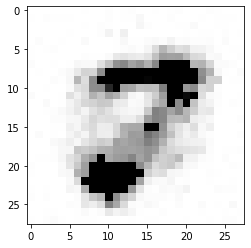

In [188]:
import matplotlib.pyplot as plt
samples = results[0]
plt.imshow(samples[30][2].reshape(28,28), cmap='gray_r');

In [ ]:
print(discr)
print(generator)